## CLASIFICADOR DE VEHÍCULOS

#### El objetivo principal que resuelve este script es clasificar qué tipo de vehículo es el representado en la imagen.
#### Una vez etiquetadas todas las fotos, se seleccionarán solo aquellas que hagan referencia a coches para una evaluación posterior de los daños.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/MasterMBD/ProyectoIMAGEN/CarInsurance") 
sys.path.append("/content/drive/MyDrive/MasterMBD/ProyectoIMAGEN/CarInsurance") 

In [ ]:
# Importar Librerias
import numpy as np
import json
import os, sys 

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import plot_model # plot del modelo

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16

In [ ]:
!pwd

/content/drive/MyDrive/MasterMBD/ProyectoIMAGEN/CarInsurance


### ANÁLISIS EXPLORATORIO DEL DATASET

Para el proyecto se usarán dos sets de datos, uno de training y otro de validación. 

In [ ]:
dir = "./training/01-whole"
len(os.listdir(dir))

920

En training hay 920 imágenes de vehículos no dañados

In [ ]:
dir = "./training/00-damage"
len(os.listdir(dir))

920

En training hay, también, 920 imágenes de coches dañados. Por lo tanto el dataset está balanceado. A su vez, se han añadido fotos de otros vehículos como barcos o bicicletas para comprobar el funcionamiento del clasificador de vehículos.

### MODELO DE CLASIFICACIÓN

Para la implementación de este modelo clasificador se empleará el modelo preentrenado VGG16 (Oxford Visual Geometry Group) siendo este la versión de 16 capas.
Gracias a la librería keras, se pueden descargar directamente sus pesos, los cuales únicamente se descargan una vez (los guardamos como vgg16.h5)

A fin de conocer más a fondo este modelo, se puede crear un esquema con la arquitectura de las capas:

In [ ]:
#!pip install pydot
#!pip install graphviz

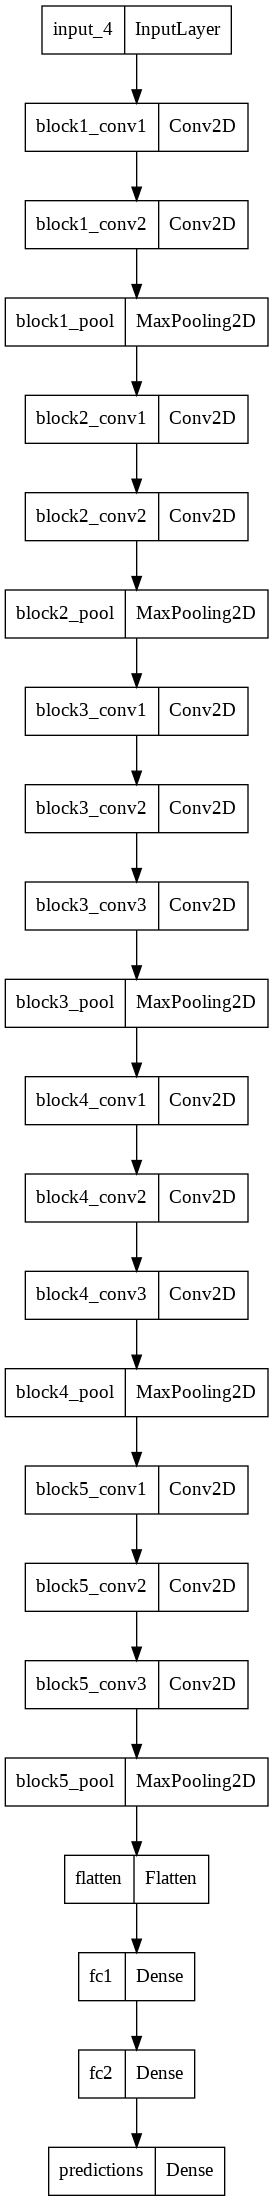

In [ ]:
# Usaremos el modelo VGG16
model = VGG16()
plot_model(model, to_file='./images/vgg.png') # guardar la imagen en del modelo en la carpeta "images"

In [ ]:
# Cargar VGG16
vgg16 = VGG16(weights='imagenet') # cargar los pesos pre-entrenados

In [ ]:
vgg16.save('models/vgg16.h5') # guardar el modelo en la carpeta "models"

In [ ]:
model_path='models/vgg16.h5'
vgg16 = VGG16(weights=model_path)

In [ ]:
# Función que prepara la imagen para que funcione con la librería de KEras
def prepare_image(img_path):
    # 1) Carga la imagen y la reescala al tamaño necesario de 224×224 pixels
    img = load_img(img_path, target_size=(224, 224))
    # 2) Convertir los pixels a un NumPy array para poder trabajar con Keras
    x = img_to_array(img)
    # 3) Expandir la forma del array
    x = np.expand_dims(x, axis=0)
    # 4) Preparar un nuevo input para el entorno de la función de Keras
    x = preprocess_input(x)
    return x

### Prueba del modelo con una imagen

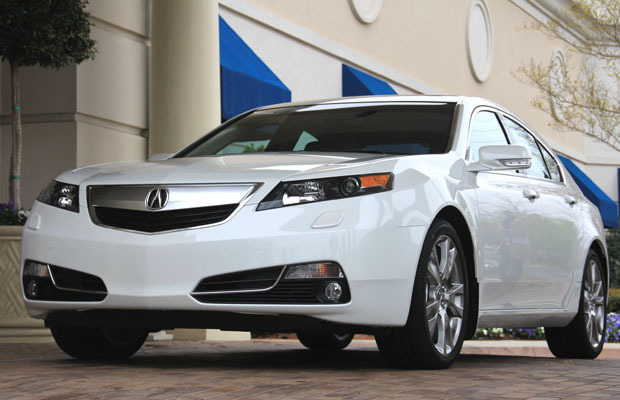

In [ ]:
# Probamos con una imagen
from IPython.display import Image, display
img_path = './training/01-whole/0009.jpg'
display(Image(filename=img_path)) # show the image

In [ ]:
# 1) Preparar imagen - con la función prepare_image
y = prepare_image(img_path)

# 2) Hacer una Predicción
preds = vgg16.predict(y)

# 3) Convertir las probabilidades a etiquetas con la clase de coche
label = decode_predictions(preds)

# 4) get_top5predictions
print("------------------------------------------------------------------------------------------------------")
print(label)
print("------------------------------------------------------------------------------------------------------")

# 5) Recoger el resultado más probable, el tipo de coche que tenga la mayor probabilidad de ser
label = label[0][0]

# 6) Imprimir la clasificación
print('%s (%.2f%%)' % (label[1], label[2]*100))

------------------------------------------------------------------------------------------------------
[[('n04285008', 'sports_car', 0.44334888), ('n03100240', 'convertible', 0.38663527), ('n03459775', 'grille', 0.037103023), ('n02974003', 'car_wheel', 0.034740705), ('n02814533', 'beach_wagon', 0.027459787)]]
------------------------------------------------------------------------------------------------------
sports_car (44.33%)


La elección del tipo de vehículo apenas tarda 1 segundo, es una clasificación rápida

## 1. Prueba en nuestro conjunto de datos

In [ ]:
from collections import Counter, defaultdict
import os
import pickle as pk

### 1.1 Extracción de las categorías más comunes de nuestro set de training

In [ ]:
# Función para quedarnos con el top 5 de categorías cada foto
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('./training/01-whole')
    for i, img_path in enumerate(img_list):
        img = prepare_image('./training/01-whole/'+img_path)
        preds = vgg16.predict(img)
        top = decode_predictions(preds)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print (i, '/', len(img_list), 'complete')
    return Counter(d)

In [ ]:
cat_counter=get_car_categories()

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [ ]:
cat_list  = [k for k, v in cat_counter.most_common()[:5]] # Devuelve una lista de los "n" elementos desde el más común al menos

Se concluye que nuestro dataset (training, vehículos sin daños) contiene más "minivans" que cualquier otro tipo de coche. La lista la siguen los coches deportivos, los descapotables, los coches de playa y los pickups: 

In [ ]:
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup')]

### 1.2 Comprobación si es un coche o no

#### **Creación de la función car_categories_gate()**
#### Esta función determina si en la foto aparece un coche o no. En el caso de que aparezca un coche se procede a la parte 2 de la práctica (La clasificación de daños)

In [ ]:
def car_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    preds = vgg16.predict(img)
    top = decode_predictions(preds)
    print ("Imagen en proceso de validación...")
    for j in top[0]:
        print(j)
        if j[0:2] in cat_list:
            print (j[0:2])
            return "Validación terminada - proceda a la evaluación de daños"
    return print("Esta imagen no se reconoce como un coche.\nPor favor, tome otra foto desde otro ángulo y vuelva a realizar la validación")

### Probamos el clasificador de "vehículo o no" con varias imágenes de nuestro set de validación

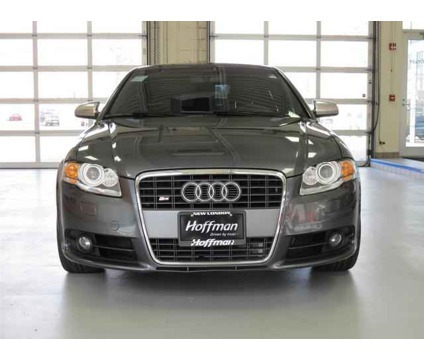

Imagen en proceso de validación...
('n04285008', 'sports_car', 0.41731283)
('n04285008', 'sports_car')


'Validación terminada - proceda a la evaluación de daños'

In [64]:
# Ejemplo con una foto de un coche de nuestro set de validación
img_path2 = './validation/01-whole/0035.jpg'
display(Image(filename=img_path2))
car_categories_gate(img_path2, cat_list)

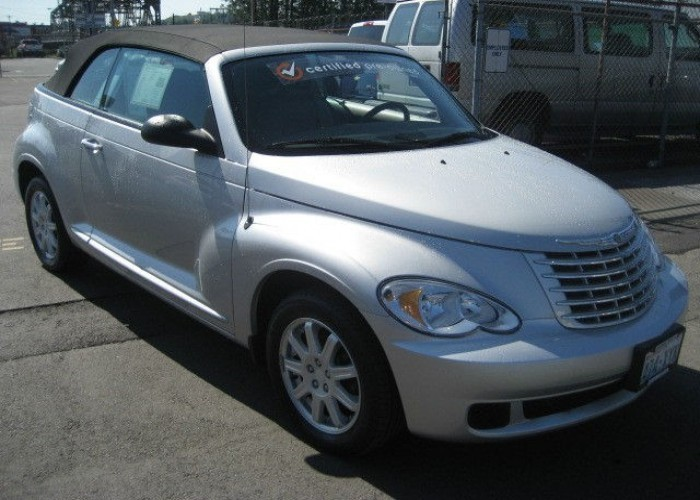

Imagen en proceso de validación...
('n03770679', 'minivan', 0.5598001)
('n03770679', 'minivan')


'Validación terminada - proceda a la evaluación de daños'

In [70]:
# Ejemplo con una foto de un coche de nuestro set de entrenamiento 
img_path3= './validation/01-whole/0086.jpg'
display(Image(filename=img_path3))
car_categories_gate(img_path3, cat_list)

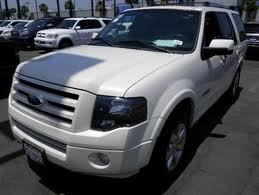

Imagen en proceso de validación...
('n03670208', 'limousine', 0.39395046)
('n03445924', 'golfcart', 0.13444777)
('n03770679', 'minivan', 0.13066429)
('n03770679', 'minivan')


'Validación terminada - proceda a la evaluación de daños'

In [69]:
# Ejemplo con una foto de un coche de nuestro set de entrenamiento
img_path4 = './validation/01-whole/0110.jpg'
display(Image(filename=img_path4))
car_categories_gate(img_path4, cat_list)

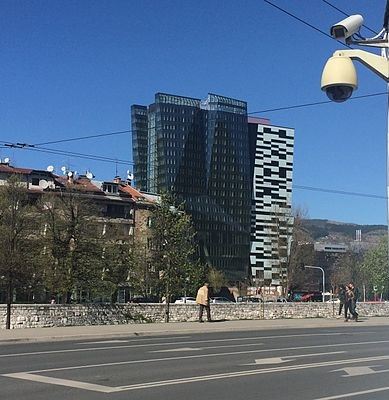

Imagen en proceso de validación...
('n02687172', 'aircraft_carrier', 0.38064343)
('n03126707', 'crane', 0.23329103)
('n06874185', 'traffic_light', 0.1093704)
('n03976657', 'pole', 0.05867534)
('n04258138', 'solar_dish', 0.023516862)
Esta imagen no se reconoce como un coche.
Por favor, tome otra foto desde otro ángulo y vuelva a realizar la validación


In [71]:
# Probamos clasificando fotos donde no aparecen coches
img_path5 = './images/02-notcars/city.jpg'
display(Image(filename=img_path5))
car_categories_gate(img_path5, cat_list)

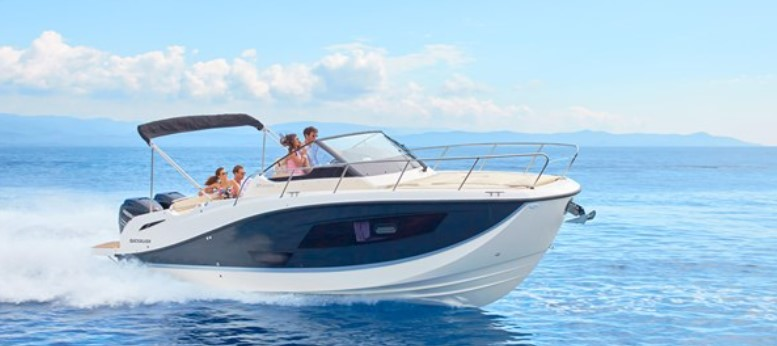

Imagen en proceso de validación...
('n04273569', 'speedboat', 0.41263983)
('n02981792', 'catamaran', 0.22116275)
('n02704792', 'amphibian', 0.16827404)
('n03662601', 'lifeboat', 0.08041948)
('n04483307', 'trimaran', 0.023575937)
Esta imagen no se reconoce como un coche.
Por favor, tome otra foto desde otro ángulo y vuelva a realizar la validación


In [72]:
img_path6 = './images/02-notcars/boat.jpg'
display(Image(filename=img_path6))
car_categories_gate(img_path6, cat_list)

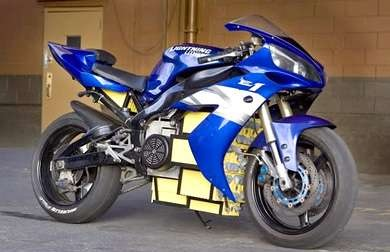

Imagen en proceso de validación...
('n03785016', 'moped', 0.676958)
('n03791053', 'motor_scooter', 0.20260552)
('n03127747', 'crash_helmet', 0.092952624)
('n03208938', 'disk_brake', 0.020860167)
('n04482393', 'tricycle', 0.0032371948)
Esta imagen no se reconoce como un coche.
Por favor, tome otra foto desde otro ángulo y vuelva a realizar la validación


In [73]:
img_path7 = './images/02-notcars/motorcycle.jpg'
display(Image(filename=img_path7))
car_categories_gate(img_path7, cat_list)

El clasificador de coches funciona correctamente con coches enteros y con imágenes sin coches en esta primera exploración. Ahora vamos a analizar como se comporta el clasificador con fotos de coches dañados.

### Clasificador de vehículos con coches dañados

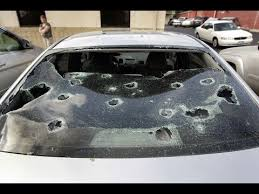

Imagen en proceso de validación...
('n03584829', 'iron', 0.31634817)
('n03770679', 'minivan', 0.10015203)
('n03770679', 'minivan')


'Validación terminada - proceda a la evaluación de daños'

In [79]:
img_path8 = './validation/00-damage/0007.JPEG'
display(Image(filename=img_path8))
car_categories_gate(img_path8, cat_list)

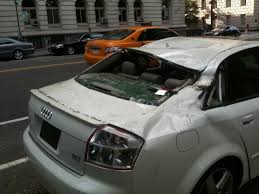

Imagen en proceso de validación...
('n02930766', 'cab', 0.20827034)
('n04461696', 'tow_truck', 0.1941567)
('n04285008', 'sports_car', 0.12848)
('n04285008', 'sports_car')


'Validación terminada - proceda a la evaluación de daños'

In [74]:
img_path9 = './validation/00-damage/0005.JPEG'
display(Image(filename=img_path9))
car_categories_gate(img_path9, cat_list)

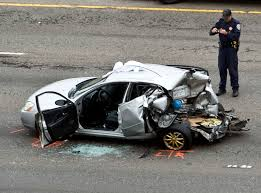

Imagen en proceso de validación...
('n03791053', 'motor_scooter', 0.18861818)
('n04037443', 'racer', 0.15909167)
('n03444034', 'go-kart', 0.10304904)
('n03127747', 'crash_helmet', 0.09143475)
('n03785016', 'moped', 0.06769048)
Esta imagen no se reconoce como un coche.
Por favor, tome otra foto desde otro ángulo y vuelva a realizar la validación


In [81]:
img_path10 = './validation/00-damage/0004.JPEG'
display(Image(filename=img_path10))
car_categories_gate(img_path10, cat_list)

El clasificador de coches cuando el coche tienen daños falla más que si el coche está entero. Ahora se va a proceder a etiquetar a las imágenes determinadas como "coches", como "coche sin daños" o "coche dañado"